# Modelling the climate and the weather

### Heather Tweedie, March 2023

GHCN (Global Historical Climatology Network)-Daily is a database of daily climate summaries from land surface stations across the globe. This study aims to determine if the weather and climate at a location can be predicted using basic machine learning techniques. Two main research questions are proposed:
1. Can a model predict the weather at a location any better than assuming the weather tomorrow will be the same as the weather today?
2. How accurately can a model predict the climate of a location a year in advance?

This notebook will focus on the first of these questions, examining prediction of temperature and precipitation data.


Journal article describing GHCN-Daily:
Menne, M.J., I. Durre, R.S. Vose, B.E. Gleason, and T.G. Houston, 2012:  An overview of the Global Historical Climatology Network-Daily Database.  Journal of Atmospheric and Oceanic Technology, 29, 897-910, doi:10.1175/JTECH-D-11-00103.1.

Dataset used:
Menne, M.J., I. Durre, B. Korzeniewski, S. McNeal, K. Thomas, X. Yin, S. Anthony, R. Ray, R.S. Vose, B.E.Gleason, and T.G. Houston, 2012: Global Historical Climatology Network - Daily (GHCN-Daily), Version 3.12, NOAA National Climatic Data Center. http://doi.org/10.7289/V5D21VHZ

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import keras.layers as layers
from GHCND import *

2023-03-22 22:30:57.447444: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-22 22:30:57.749774: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-22 22:30:57.831192: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-22 22:30:57.831251: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

## Retrieve data

To filter the stations used, only stations with fewer than 100 missing data points were considered. The number of missing values is calculated in the script `get_station_counts.py` and (took ~50 minutes to run on my laptop). These counts are stored in the file `stat_counts_tmax.json` and `stat_counts_prcp` in the json format for ease of future loading, as this script need only be run once for a given variable and set of stations. The file is opened and read below, then all stations with 100 or fewer missing data points saved in seperate lists. 

In [2]:
f = open('data/stat_counts_tmax.json')
counts_tmax = json.load(f)
f = open('data/stat_counts_prcp.json')
counts_prcp = json.load(f)

# find all stations with no data gaps
no_gaps_tmax = [name for name, count in counts_tmax.items() if count <= 100]
print(f"Number of tmax stations found: {len(no_gaps_tmax)}")
no_gaps_prcp = [name for name, count in counts_prcp.items() if count <= 100]
print(f"Number of prcp stations found: {len(no_gaps_prcp)}")

good_stations = list(set(no_gaps_tmax).intersection(no_gaps_prcp))
print(f"Number of stations with few temp and precip gaps: {len(good_stations)}")

Number of tmax stations found: 103
Number of prcp stations found: 112
Number of stations with few temp and precip gaps: 76


Retrieve data for the given station and variables. An instance of the GHCND class is created, then the `readCountriesFile` and `readStationsFile` methods called on it. These methods extract information on the countries and stations available and stores these in fields as dictionaries. The list of station names is stored as a seperate list for future use.

The station to be investigated is set from the list of those with few missing date points. The required file name is constructed from the station name, which is then used to build the url required to fetch the data from the course-provided web directory of data files. The required data file is then copied from this remote directory to a local one (`/data`). The `processFile` method is then called on the GHCND class instance to extract the data from this file into a dictionary.

Data for the temperature and precipitation are extracted from this dictionary into instances of the `Variable` class, with fields for the values and their corresponding dates.

In [3]:
# create instance of the GHCND class and extract information on countries and stations from their respective files
ghn = GHCND()
ghn.readCountriesFile()
ghn.readStationsFile()

# get list of station names
station_names = ghn.getStatKeyNames()

# set station to be investigated
#station = good_stations[50]
station = 'ASN00030124'
print(f"Station selected: {station}")

# get url for a given station index
fileName = f"{station}.dly"
print(f"Filename: {fileName}")
urlName = f"http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/ghcnd/ghcnd_gsn/{fileName}"
print(f"url name: {urlName}")

# copy station data from remote to local
destination = f"data/stations_daily/{fileName}"
print(f"destination: {destination}")
urllib.request.urlretrieve(urlName, destination)
station_data = ghn.processFile(destination)
print(f"Station details: {ghn.getStation(station)}")

# extract data for specified variable into instances of the Variable class
tmax = Variable(ghn.getVar(station_data, 'TMAX'), "max temp (degC)", ghn.stationDict[station].name)
tmax.convert_time()
tmax_dates = tmax.get_dates()
tmax_vals = tmax.get_vals()
print(f"Extracted {len(tmax_vals)} maximum temperature values")

prcp = Variable(ghn.getVar(station_data, 'PRCP'), "precipitation (mm)", ghn.stationDict[station].name)
prcp.convert_time()
prcp_dates = prcp.get_dates()
prcp_vals = prcp.get_vals()
print(f"Extracted {len(prcp_vals)} precipitation values")


Read 219 countries and codes
Read 991 stations from the GSN
Station selected: ASN00030124
Filename: ASN00030124.dly
url name: http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/ghcnd/ghcnd_gsn/ASN00030124.dly
destination: data/stations_daily/ASN00030124.dly
Station details: ASN00030124 is GEORGETOWN AIRPORT, Australia at -18.3039 143.5306 301.8
Extracted 5930 maximum temperature values
Extracted 5958 precipitation values


## Prepare data for training

To improve the performance and training stavility of the model, the date are normalised by calling the `normalise` method, which subtracts the mean of the entire dataset then subtracts the maximum value for each data point. The data are then plotted.

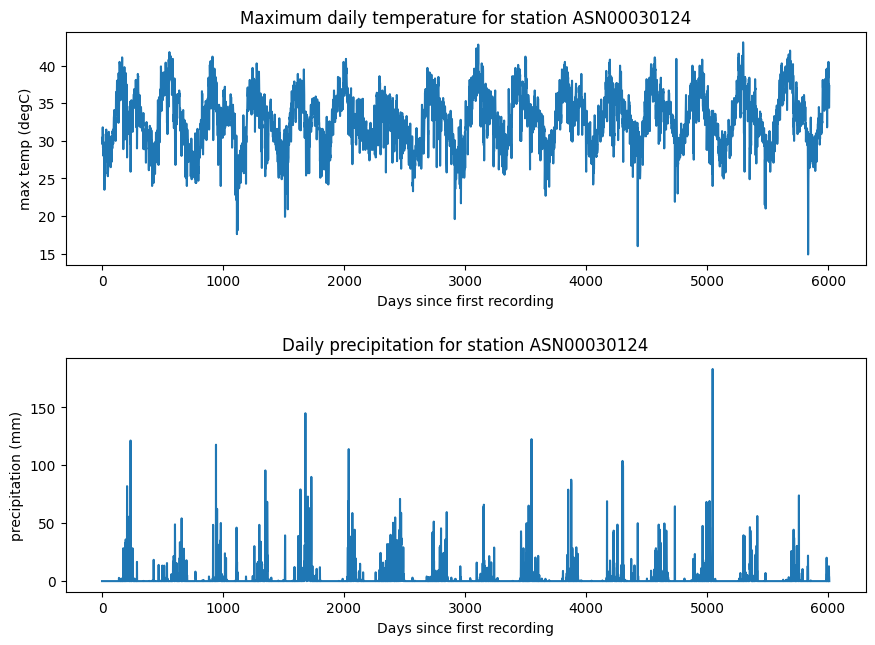

In [15]:
# normalise data, and save means and maximums for later use
tmax_normalised = tmax.normalise(tmax_vals)
tmax_mean = np.mean(tmax_vals)
tmax_max = np.max(tmax_vals)
prcp_normalised = prcp.normalise(prcp_vals)
prcp_mean = np.mean(prcp_vals)
prcp_max = np.max(prcp_vals)

# plot means and normalised means
fig, ax = plt.subplots(2, 1, figsize = (10, 7))
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
ax[0].plot(tmax_dates, tmax_vals)
ax[0].set_xlabel("Days since first recording")
ax[0].set_ylabel(f"{tmax.get_label()}")
ax[0].set_title(f"Maximum daily temperature for station {station}")

ax[1].plot(prcp_dates, prcp_vals)
ax[1].set_xlabel("Days since first recording")
ax[1].set_ylabel(f"{prcp.get_label()}")
ax[1].set_title(f"Daily precipitation for station {station}")

plt.savefig('figures/weather_input_data.svg', format = 'svg')



The data are divided into training, validating, and testing datasets. The training dataset must be the largest in order to provide sufficient material for the model to achieve a good performance. The testing dataset is smaller, but large enough that the model has sufficient input for predicting future sequences. The validation dataset is the smallest. A training:testing:validation ratio of 0.7:0.2:0.1 is used.

The offset describes how far into the future the model will predict. An offset of 1 is used here, meaning that the model will predict one day ahead. The window size dictates how much data the model is trained on in a single batch. If this is too small, the model will not perform well, however it must be smaller than the validation dataset minus the offset, otherwise it will be impossible to shape the dataset as necessary in later steps. It was found during testing that a window size of 60 worked well and gave a good performance.

The divided datasets are then split into a series of overlapping windows with length `WINDOW_SIZE`, and an associated value `OFFSET` points further ahead in the time series. These are the input windows and targets on which the model will be trained, validated and tested.

These windows are reshaped from (number of windows, window size) to (number of windows, window size, number of features), where 'number of features' is the number of variables being used in this model's training, in this case, two. 

In [23]:
WINDOW_SIZE = 60
OFFSET = 1

# make sure arrays are the same length
if len(tmax_normalised > len(prcp_normalised)):
    tmax_normalised = tmax_normalised[:len(prcp_normalised)]
if len(prcp_normalised > len(tmax_normalised)):
    prcp_normalised = prcp_normalised[:len(tmax_normalised)]

# join all variable arrays into one n-d array
all_vals = np.vstack((tmax_normalised, prcp_normalised)).T
print(f"Shape of combined data: {np.shape(all_vals)}")

# calculate appropriate divisions of data
test_len = int(len(all_vals) * 0.2)
train_len = int(len(all_vals) * 0.7)
validate_len = int(len(all_vals) * 0.1)

print(f"Length of training data: {train_len}")
print(f"Length of validation data: {validate_len}")
print(f"Length of testing data: {test_len}")

# divide data into training, validating and testing sets
test = all_vals[:test_len,:]
train = all_vals[test_len+1:test_len+train_len,:]
validate = all_vals[test_len+train_len+1:,:]

# split data into input windows and targets
input_test, target_test = shapeArray(test, WINDOW_SIZE, OFFSET)
input_train, target_train = shapeArray(train, WINDOW_SIZE, OFFSET)
input_validate, target_validate = shapeArray(validate, WINDOW_SIZE, OFFSET)

# reshape the data into the correct format for input into the model
n_features = 2
print(f"Training input shape before reshaping: {np.shape(input_train)}")
input_train = input_train.reshape((input_train.shape[0], input_train.shape[1], n_features))
input_test = input_test.reshape((input_test.shape[0], input_test.shape[1], n_features))
input_validate = input_validate.reshape((input_validate.shape[0], input_validate.shape[1], n_features))
print(f"Training input shape after reshaping: {np.shape(input_train)}")




Shape of combined data: (5930, 2)
Length of training data: 4151
Length of validation data: 593
Length of testing data: 1186
Training input shape before reshaping: (4090, 60, 2)
Training input shape after reshaping: (4090, 60, 2)


## Train and predict

A model featuring LSTM layers is trained on the input data defined above. The LSTM layers allow the model to be trained on sequential date, and predict based on these longer sequences.

In [6]:
model = keras.models.Sequential()
model.add(layers.LSTM(64, input_shape = (None, 2), activation = 'relu', return_sequences = True))
model.add(layers.LSTM(128, activation = 'relu', return_sequences = False))
model.add(layers.Dense(2, activation = "linear"))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')

model.summary()

# train model and extract final loss
history = model.fit(input_train, target_train, epochs = 50, validation_data = (input_validate, target_validate))
cost = history.history['loss']
val_cost = history.history['val_loss']


2023-03-22 22:31:04.182191: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-22 22:31:04.182290: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-22 22:31:04.182329: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (penguin): /proc/driver/nvidia/version does not exist
2023-03-22 22:31:04.187567: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 64)          17152     
                                                                 
 lstm_1 (LSTM)               (None, 128)               98816     
                                                                 
 dense (Dense)               (None, 2)                 258       
                                                                 
Total params: 116,226
Trainable params: 116,226
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
128/128 [==============================] - 7s 43ms/step - loss: 0.0028 - val_loss: 0.0014
Epoch 2/50
128/128 [==============================] - 6s 44ms/step - loss: 0.0025 - val_loss: 0.0015
Epoch 3/50
128/128 [==============================] - 7s 53ms/step - loss: 0.0024 - val_loss: 0.0012
Epoch 4/50


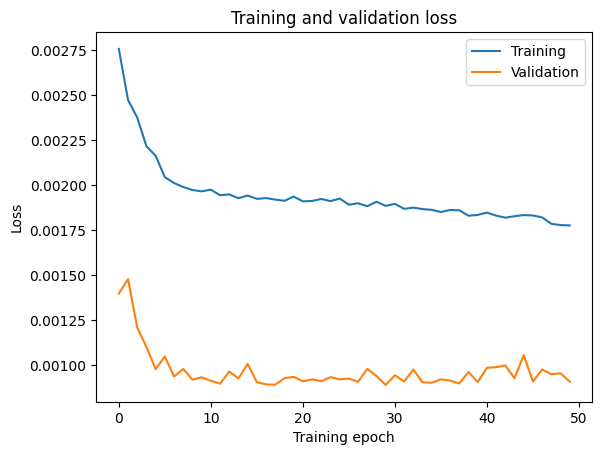

In [7]:
# plot the training and validation losses
fig, ax = plt.subplots()
ax.plot(cost, label = "Training")
ax.plot(val_cost, label = "Validation")
ax.set_xlabel("Training epoch")
ax.set_ylabel("Loss")
ax.legend()
ax.set_title("Training and validation loss")
plt.savefig('figures/weather_loss.svg', format = 'svg')


The model is now used to predict the next of a series of days of data, the results of which are plotted below.

36/36 [==============================] - 1s 15ms/step
(1126, 2)


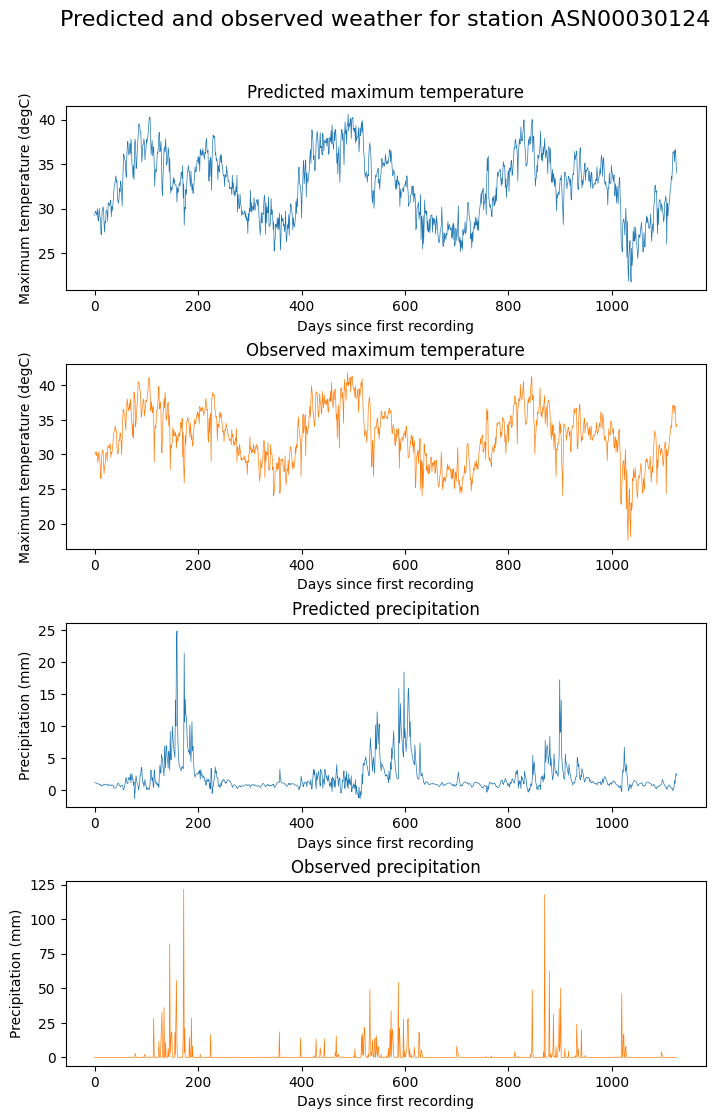

In [12]:
prediction = model.predict(input_test)

# de-normalise data for plotting
plot_target_tmax = (tmax.de_normalise(target_test[:,0], tmax_max, tmax_mean))
plot_pred_tmax = (tmax.de_normalise(prediction[:,0], tmax_max, tmax_mean))
plot_target_prcp = (prcp.de_normalise(target_test[:,1], prcp_max, prcp_mean))
plot_pred_prcp = (prcp.de_normalise(prediction[:,1], prcp_max, prcp_mean))

# plot observed and predicted data
fig, ax = plt.subplots(4, 1, figsize = (8, 12))
fig.suptitle(f"Predicted and observed weather for station {station}", fontsize = 16)
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.2,
                    hspace=0.4)

ax[0].plot(plot_pred_tmax, color = 'tab:blue', linewidth = 0.5)
ax[0].set_xlabel("Days since first recording")
ax[0].set_ylabel("Maximum temperature (degC)")
ax[0].set_title(f"Predicted maximum temperature")

ax[1].plot(plot_target_tmax, color = 'tab:orange', linewidth = 0.5)
ax[1].set_xlabel("Days since first recording")
ax[1].set_ylabel("Maximum temperature (degC)")
ax[1].set_title(f"Observed maximum temperature")

ax[2].plot(plot_pred_prcp, color = 'tab:blue', linewidth = 0.5)
ax[2].set_xlabel("Days since first recording")
ax[2].set_ylabel("Precipitation (mm)")
ax[2].set_title(f"Predicted precipitation")

ax[3].plot(plot_target_prcp, color = 'tab:orange', linewidth = 0.5)
ax[3].set_xlabel("Days since first recording")
ax[3].set_ylabel("Precipitation (mm)")
ax[3].set_title(f"Observed precipitation")

plt.savefig('figures/weather_prediction.svg', format = 'svg')



A more detailed view of this is plotted, showing the first six months of these data. The data are also compared against the assumption that the weather the next day will be the same as today.

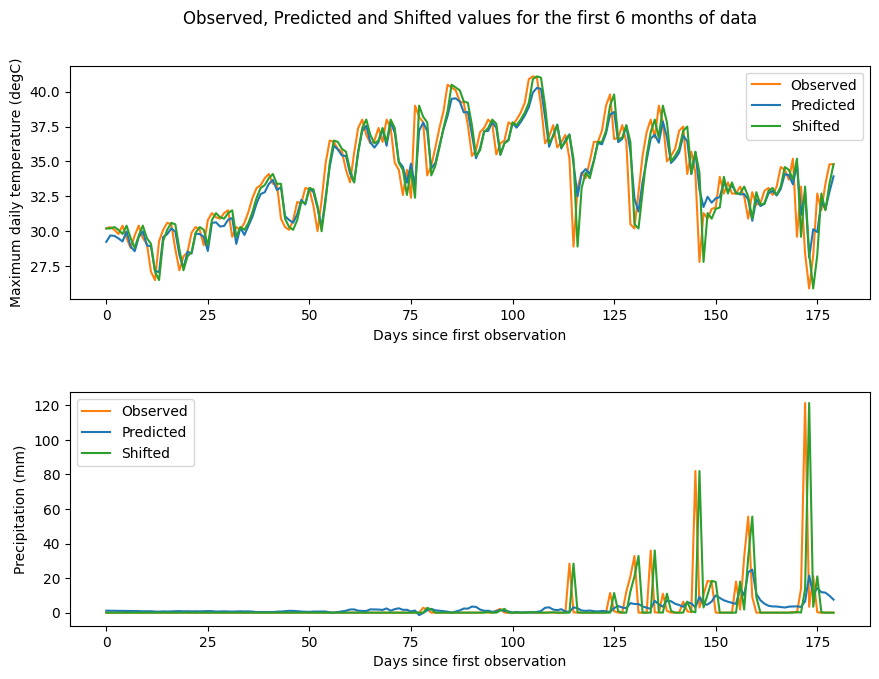

In [13]:
months_to_plot = 6

# calculae predictions assuming the next day will be the same as today
shifted_tmax = shift(plot_target_tmax)
shifted_prcp = shift(plot_target_prcp)

# plot observations and predictions for the first 6 months of data
fig, ax = plt.subplots(2, 1, figsize = (10, 7))
fig.suptitle(f"Observed, Predicted and Shifted values for the first {months_to_plot} months of data")
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)

ax[0].plot(plot_target_tmax[:months_to_plot*30], label = "Observed", color = 'tab:orange')
ax[0].plot(plot_pred_tmax[:months_to_plot*30], label = "Predicted", color = 'tab:blue')
ax[0].plot(shifted_tmax[:months_to_plot*30], label = "Shifted", color = 'tab:green')
ax[0].set_xlabel("Days since first observation")
ax[0].set_ylabel("Maximum daily temperature (degC)")
ax[0].legend()

ax[1].plot(plot_target_prcp[:months_to_plot*30], label = "Observed", color = 'tab:orange')
ax[1].plot(plot_pred_prcp[:months_to_plot*30], label = "Predicted", color = 'tab:blue')
ax[1].plot(shifted_prcp[:months_to_plot*30], label = "Shifted", color = 'tab:green')
ax[1].set_xlabel("Days since first observation")
ax[1].set_ylabel("Precipitation (mm)")
ax[1].legend()

plt.savefig('figures/weather_detailed_prediction.svg', format = 'svg')



In [21]:
fake_mse_tmax = weather_fake_mse(tmax_normalised)
print(f"Max temperature mse: {np.round(fake_mse_tmax, 5)}")

fake_mse_prcp = weather_fake_mse(prcp_normalised)
print(f"Precipitation msa: {np.round(fake_mse_prcp, 5)}")

Max temperature mse: 0.00153
Precipitation msa: 0.00347


The model does well at predicting the overall shape of the weather observations, particularly for the weather. It is, however, less accurate at predicting extremes and rapid changes. This is particularly evident in the precipitation data. Although peaking in similar places, these peaks are generally about three times too small. The model also introduces a lot of variability to the predictions between peaks, while the observations remain at zero until there is a sudden increase. 

It appears to be relatively straightforward to predict the next day's temperature given those that have come before, but precipitation is much more complex. There is seemingly little or insufficient indication in solely the temperature and past precipitation data of what the future precipitation will be.

The model does, however, perform more accurately than assuming that the weather tomorrow will be the same as today. This baseline mean-squared-error for the temperature data is calculated to be 0.00153, and for the precipitation data, 0.00347. The training loss from the model is greater than the fake mse for the temperature data, but smaller than that for the precipitation data. This is likely due to the variability between peaks and the poor performance predicting the height of these peaks for the precipitation data, increasing the overall mean-squared error during training, even if the temperature predicitons are reasonably accurate. The validation loss however is lower than both of the fake mean-squared-error values calculated. Since this is a more indicator of how well the model will perform on unseen data, it is reasonable to conclude that this model does predict the maximum temperature and precipitation a day ahead more accurately than if one were to assume that tomorrow's weather would be the same as today's.